In [19]:
import gym
from amalearn.environment import EnvironmentBase
import math

class TenArmedBanditEnvironment(EnvironmentBase):
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        super(TenArmedBanditEnvironment, self).__init__(action_space, state_space, id, container)
        self.arms_rewards = rewards
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward()

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [20]:
from amalearn.reward import RewardBase
import numpy as np

class GaussianReward(RewardBase):
    def __init__(self, mean, std):
        super(GaussianReward, self).__init__()
        self.mean = mean
        self.std = std

    def get_reward(self):
        return np.random.normal(loc=self.mean, scale=self.std)


In [21]:
import numpy as np
def update_param(u_in, sigma_in, itter_num, reward):
    u_out = u_in + (1/(itter_num+1))*(reward - u_in)
    sigma_out = sigma_in/(itter_num + 1)
    sigma_out = sigma_out*itter_num
    return u_out, sigma_out

In [22]:
def thompson_sampling(q_values):
    samples=np.zeros(10)
    for i in range(10):
        samples[i] = np.random.normal( q_values[i,0], q_values[i,1] )
    return np.argmax(samples)

In [23]:
import numpy as np
from amalearn.agent import AgentBase


class ThopmsonBanditAgent(AgentBase):
    def __init__(self, id, environment):
        super(ThopmsonBanditAgent, self).__init__(id, environment)
        self.Q_values = np.zeros((10,2))
        for i in range(10):
            self.Q_values[i,1]=100
        self.itter_num = np.zeros(10)
    
    def reset_attr(self):
        self.Q_values = np.zeros((10,2))
        for i in range(10):
            self.Q_values[i,1]=100
        self.itter_num = np.zeros(10)

    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        best_action = thompson_sampling(self.Q_values)
        obs, r, d, i = self.environment.step(best_action)
        self.Q_values[best_action,0], self.Q_values[best_action,1] = update_param(self.Q_values[best_action,0], self.Q_values[best_action,1], self.itter_num[best_action], r)
        self.itter_num[best_action] +=1
        #print(obs, r, d, i)
        #self.environment.render()
        if d == True:
            self.environment.reset()
            self.reset_attr()
            
        return r, best_action


In [37]:
def average_percentage(W_S, all_actions):
    best_action = all_actions [-2]
    percetage_of_best_action = np.zeros(all_actions.shape [0] - W_S+1)
    for window_num in range(all_actions.shape [0] - W_S+1):
        temp = np.count_nonzero(all_actions[window_num : window_num + W_S] == best_action)
        percetage_of_best_action[window_num] = temp/W_S
    return percetage_of_best_action

In [38]:

def normalize(x):
    mm= np.max(x)-np.min(x)
    y = 2*(x - np.mean(x))/mm
    return y
def average_regret( all_rewards):
    #all_actions = normalize(all_actions)
    best_reward = np.sum(all_rewards[-10 : -1] )/(9)
    regret = np.zeros(all_rewards.shape [0])
    regret = best_reward - all_rewards
    regret = np.cumsum(regret)
    return regret

In [41]:
import numpy as np
import matplotlib.pyplot as plt
step = 1000
mean_std = np.zeros((10,2))
for i in range(10):
    mean_std[i,1]=1
rewards = [GaussianReward(mean_std[i,0], mean_std[i,1]) for i in range(10)]
env = TenArmedBanditEnvironment(rewards, 1000, '1')
agent = ThopmsonBanditAgent('1', env)
run_size = 20
q = np.zeros((run_size, 1000))
r = np.zeros((run_size, 1000))
for run in range(run_size):
    for step in range(1000):
        r[run, step] ,q[run, step] = agent.take_action()
window_size = 50
best_action_percentage = np.zeros((run_size, 1000-49))
avrg_reward = np.zeros((run_size, 1000))
for run in range(run_size):
    best_action_percentage[run, :] = average_percentage(window_size, q[run, :])
    avrg_reward[run,:] = (average_regret( q[run, :]))
average_percentage = np.mean( best_action_percentage, axis = 0)
avrg_regret= (np.mean( avrg_reward, axis = 0))
    



Text(0, 0.5, 'Probablity')

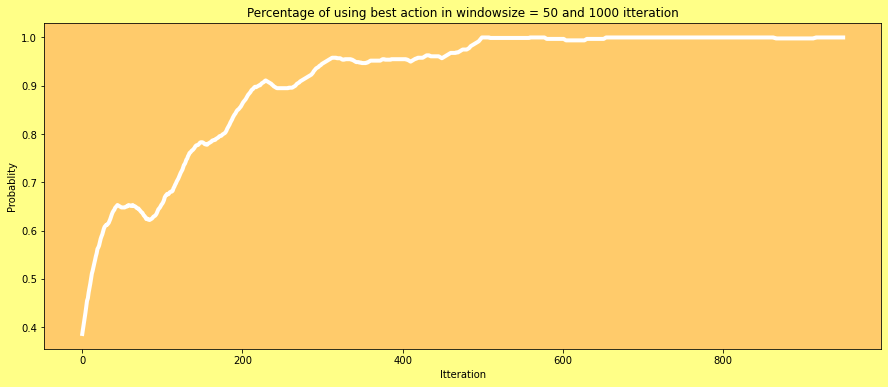

In [42]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(average_percentage, 'k-', lw=4, color='white')
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Percentage of using best action in windowsize = 50 and 1000 itteration')
plt.xlabel('Itteration')
plt.ylabel('Probablity')


Text(0, 0.5, 'Award')

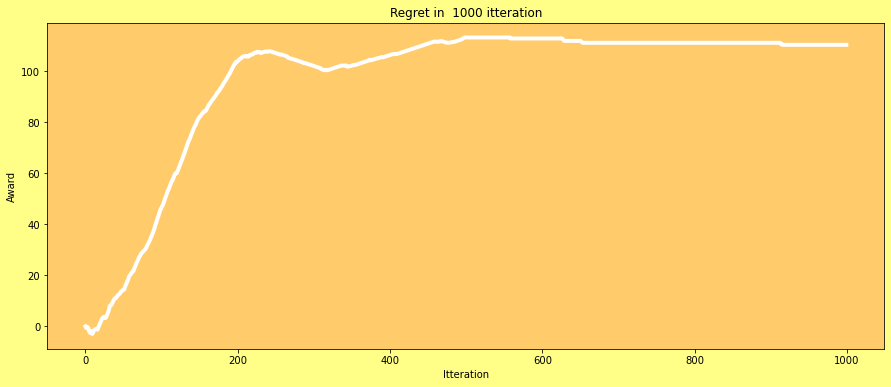

In [43]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(avrg_regret , 'k-', lw=4, color='white')
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Regret in  1000 itteration')
plt.xlabel('Itteration')
plt.ylabel('Award')